In [1]:
# Cell 0 — imports & helpers
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import joblib   # optional: to save scaler

# helper: safe head print
def quick(df, n=5):
    display(df.head(n))
    print(df.shape)


In [3]:
# preferred: use C engine (fast) and keep low_memory to avoid mixed dtypes
df = pd.read_csv(raw_csv, low_memory=False, engine='c', comment='#')
print("loaded shape:", df.shape)
df.head()


loaded shape: (39315, 289)


,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_dr2_id,gaia_dr3_id,default_flag,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,1,...,2023-09-19,2023-08,2023-09-19,2.0,1.0,2.0,0.0,0.0,0.0,0.0
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-05-14,2008-01,2014-05-14,2.0,1.0,2.0,0.0,0.0,0.0,0.0
2,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-07-23,2011-08,2014-07-23,2.0,1.0,2.0,0.0,0.0,0.0,0.0
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,1,...,2018-09-04,2017-03,2018-09-06,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,2018-04-25,2011-08,2014-07-23,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
# Cell 2 — expected features (from spec) and keep available ones
expected = {
 "pl_rade":"planet radius (Earth radii)",
 "pl_bmasse":"planet mass (Earth masses)",
 "pl_orbper":"orbital period (days)",
 "pl_orbsmax":"semi-major axis (AU)",
 "pl_eqt":"equilibrium temperature (K)",
 "pl_dens":"planet density",
 "st_teff":"host star effective temperature (K)",
 "st_lum":"star luminosity (solar units)",
 "st_met":"star metallicity",
 "st_spectype":"star spectral type"
}

# keep columns that exist in df
present = [c for c in expected.keys() if c in df.columns]
missing_expected = [c for c in expected.keys() if c not in df.columns]
print("present expected features:", present)
print("missing expected features (may require conversions or are absent):", missing_expected)

# Create a working frame with the present expected features plus some context columns for later use
work_cols = present + [c for c in ["pl_name","hostname","disc_pubdate"] if c in df.columns]
df_work = df[work_cols].copy()
print("working df shape:", df_work.shape)
quick(df_work)


present expected features: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met', 'st_spectype']
missing expected features (may require conversions or are absent): []
working df shape: (39315, 13)


,pl_rade,pl_bmasse,pl_orbper,pl_orbsmax,pl_eqt,pl_dens,st_teff,st_lum,st_met,st_spectype,pl_name,hostname,disc_pubdate
0,NaN,4914.898486,323.21000,1.178,NaN,NaN,4874.0,1.97823,-0.26,G8 III,11 Com b,11 Com,2008-01
1,NaN,6165.600000,326.03000,1.290,NaN,NaN,4742.0,2.24300,-0.35,G8 III,11 Com b,11 Com,2008-01
2,NaN,5434.700000,NaN,1.210,NaN,NaN,NaN,NaN,NaN,NaN,11 Com b,11 Com,2008-01
3,NaN,4684.814200,516.21997,1.530,NaN,NaN,4213.0,NaN,-0.02,NaN,11 UMi b,11 UMi,2009-10
4,NaN,3432.400000,NaN,1.510,NaN,NaN,NaN,NaN,NaN,NaN,11 UMi b,11 UMi,2009-10


(39315, 13)


In [5]:
# Cell 3 — missing, nulls, duplicates overview
missing_counts = df_work.isnull().sum().sort_values(ascending=False)
print("Top missing counts:\n", missing_counts.head(20))
print("\nTotal missing (cells):", df_work.isnull().sum().sum())
print("Duplicate rows count:", df_work.duplicated().sum())


Top missing counts:
 pl_dens         36568
st_spectype     36404
pl_bmasse       32182
st_lum          29631
pl_eqt          22067
pl_orbsmax      17332
st_met          14503
pl_rade         12212
st_teff          3538
pl_orbper        3354
disc_pubdate       20
pl_name             0
hostname            0
dtype: int64

Total missing (cells): 207811
Duplicate rows count: 5498


In [6]:
# Cell 4 — summary statistics
display(df_work.describe(include='all').T)   # full summary for report
# save a CSV summary for your notebooks folder
os.makedirs("../notebooks", exist_ok=True)
df_work.describe(include='all').T.to_csv("../notebooks/summary_stats_raw_subset.csv")
print("Saved summary to ../notebooks/summary_stats_raw_subset.csv")


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pl_rade,27103.0,NaN,NaN,NaN,5.452616,71.782534,0.27,1.55,2.3,3.27,4282.98
pl_bmasse,7133.0,NaN,NaN,NaN,742.775134,1561.730576,0.015,13.323457,191.33366,687.326229,25426.4
pl_orbper,35961.0,NaN,NaN,NaN,12164.247196,2121106.04109,0.090706,4.398836,10.339239,26.5841,402000000.0
pl_orbsmax,21983.0,NaN,NaN,NaN,4.757401,180.934172,0.0044,0.0545,0.10082,0.2192,19000.0
pl_eqt,17248.0,NaN,NaN,NaN,879.886074,428.422019,34.0,568.0,797.0,1104.0,4050.0
pl_dens,2747.0,NaN,NaN,NaN,6.142082,64.956936,0.00074,0.561,1.32,3.67,2331.0
st_teff,35777.0,NaN,NaN,NaN,5460.559432,994.710927,415.0,5097.0,5612.0,5951.0,57000.0
st_lum,9684.0,NaN,NaN,NaN,-0.150585,0.719291,-4.66,-0.46344,-0.08379,0.303312,3.26076
st_met,24812.0,NaN,NaN,NaN,-0.022288,0.226993,-2.5,-0.15,-0.00225,0.12,7.79
st_spectype,2911,292,G0 V,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved summary to ../notebooks/summary_stats_raw_subset.csv


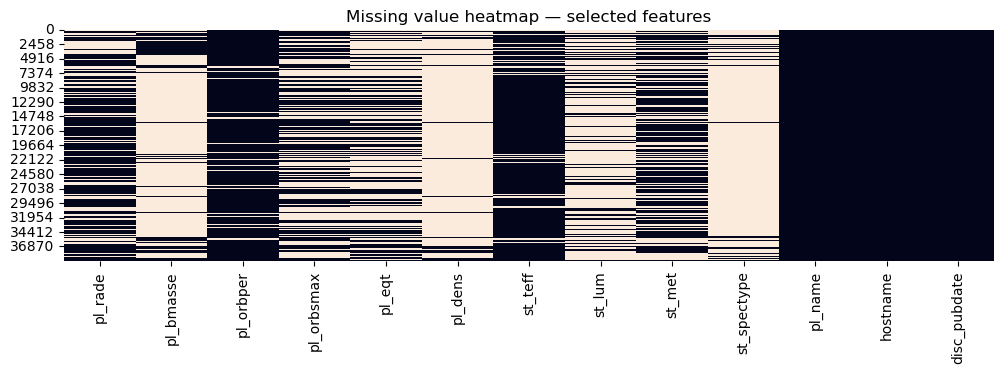

In [7]:
# Cell 5 — missing value heatmap
plt.figure(figsize=(12,3))
sns.heatmap(df_work.isnull(), cbar=False)
plt.title("Missing value heatmap — selected features")
plt.show()


In [8]:
# Cell 6 — drop rows missing all expected numeric features (completely missing rows)
all_expected = [c for c in expected.keys() if c in df_work.columns]
print("all_expected in working df:", all_expected)
before = df_work.shape[0]
df_work = df_work.dropna(axis=0, how='all', subset=all_expected)
after = df_work.shape[0]
print(f"dropped {before-after} rows that were completely empty in expected features")


all_expected in working df: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met', 'st_spectype']
dropped 109 rows that were completely empty in expected features


In [9]:
# Cell 7 — imputation strategy
# numeric planetary physical values: median (robust)
num_planet = [c for c in ['pl_rade','pl_bmasse','pl_orbper','pl_orbsmax','pl_eqt','pl_dens'] if c in df_work.columns]
star_temp = 'st_teff' if 'st_teff' in df_work.columns else None
star_lum = 'st_lum' if 'st_lum' in df_work.columns else None
star_met = 'st_met' if 'st_met' in df_work.columns else None
star_type = 'st_spectype' if 'st_spectype' in df_work.columns else None

print("planet numeric cols for median impute:", num_planet)
for c in num_planet:
    med = df_work[c].median()
    df_work[c].fillna(med, inplace=True)

if star_temp:
    df_work[star_temp].fillna(df_work[star_temp].median(), inplace=True)
if star_type:
    df_work[star_type].fillna(df_work[star_type].mode().iloc[0] if not df_work[star_type].mode().empty else "Unknown", inplace=True)

# verify
print("Missing after imputation (per column):")
print(df_work.isnull().sum()[[c for c in df_work.columns]])


planet numeric cols for median impute: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens']
Missing after imputation (per column):
pl_rade             0
pl_bmasse           0
pl_orbper           0
pl_orbsmax          0
pl_eqt              0
pl_dens             0
st_teff             0
st_lum          29522
st_met          14394
st_spectype         0
pl_name             0
hostname            0
disc_pubdate        0
dtype: int64


C:\Users\shish\AppData\Local\Temp\ipykernel_13252\256165395.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_work[c].fillna(med, inplace=True)
C:\Users\shish\AppData\Local\Temp\ipykernel_13252\256165395.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

In [10]:
# Cell 8 — compute z-score and IQR flags for key numeric columns
from scipy import stats

numeric_cols = [c for c in df_work.select_dtypes(include=[np.number]).columns if c in num_planet + [star_temp, star_lum, star_met] if c]
z_outliers = {}
iqr_outliers = {}
for c in numeric_cols:
    series = df_work[c].dropna()
    z = np.abs(stats.zscore(series))
    z_count = (z > 3).sum()   # standard z > 3
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    iqr_count = ((series < lower) | (series > upper)).sum()
    z_outliers[c] = int(z_count)
    iqr_outliers[c] = int(iqr_count)

print("Z-score outliers (sample):")
print({k:v for k,v in z_outliers.items()})
print("\nIQR outliers (sample):")
print({k:v for k,v in iqr_outliers.items()})


Z-score outliers (sample):
{'pl_rade': 16, 'pl_bmasse': 642, 'pl_orbper': 3, 'pl_orbsmax': 32, 'pl_eqt': 856, 'pl_dens': 21, 'st_teff': 101, 'st_lum': 168, 'st_met': 170}

IQR outliers (sample):
{'pl_rade': 5504, 'pl_bmasse': 7132, 'pl_orbper': 5242, 'pl_orbsmax': 11905, 'pl_eqt': 17226, 'pl_dens': 2744, 'st_teff': 2894, 'st_lum': 539, 'st_met': 439}


In [11]:
# Cell 9 — remove physically impossible values
# Negative radius or zero, impossible temperatures < 0 K (or < -300C ~ -27K unrealistic)
before = df_work.shape[0]
if 'pl_rade' in df_work.columns:
    df_work = df_work[df_work['pl_rade'] > 0]
if 'pl_eqt' in df_work.columns:
    # remove non-physical (<=0)
    df_work = df_work[df_work['pl_eqt'] > 0]
after = df_work.shape[0]
print("removed physically impossible rows:", before-after)


removed physically impossible rows: 0


In [12]:
# Cell 10 — capping numeric columns with IQR method
def cap_iqr(series):
    if series.dropna().empty:
        return series
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return series.clip(lower, upper)

capped_cols = [c for c in numeric_cols]  # columns to cap
for col in capped_cols:
    df_work[col] = cap_iqr(df_work[col])
print("IQR capping applied to columns:", capped_cols)


IQR capping applied to columns: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met']


In [13]:
# Optional — remove rows with z-score > 4 in any important numeric col (use with caution)
threshold = 4
mask = np.ones(len(df_work), dtype=bool)
for c in numeric_cols:
    s = df_work[c]
    # avoid nan issues
    z = np.abs((s - s.mean())/ (s.std(ddof=0) + 1e-12))
    mask &= (z <= threshold) | (s.isnull())
before = df_work.shape[0]
df_work = df_work[mask]
after = df_work.shape[0]
print("rows removed by z-score filter:", before - after)


rows removed by z-score filter: 0


In [14]:
# Cell 12 — unit standardization if alternate unit columns present
# Jupiter radius -> Earth radii (1 Rj = 11.209 Re)
# Jupiter mass -> Earth masses (1 Mj = 317.8 Me)
# Distance in km -> AU (1 AU = 1.495978707e8 km)
converted = []

if 'pl_radj' in df_work.columns and 'pl_rade' not in df_work.columns:
    df_work['pl_rade'] = df_work['pl_radj'] * 11.209
    df_work.drop(columns=['pl_radj'], inplace=True, errors='ignore')
    converted.append('pl_radj->pl_rade')

if 'pl_bmassj' in df_work.columns and 'pl_bmasse' not in df_work.columns:
    df_work['pl_bmasse'] = df_work['pl_bmassj'] * 317.8
    df_work.drop(columns=['pl_bmassj'], inplace=True, errors='ignore')
    converted.append('pl_bmassj->pl_bmasse')

# Example km->AU conversion if "pl_orbsmax_km" exists
if 'pl_orbsmax_km' in df_work.columns and 'pl_orbsmax' not in df_work.columns:
    df_work['pl_orbsmax'] = df_work['pl_orbsmax_km'] / 1.495978707e8
    df_work.drop(columns=['pl_orbsmax_km'], inplace=True, errors='ignore')
    converted.append('pl_orbsmax_km->pl_orbsmax')

print("conversions performed:", converted)


conversions performed: []


In [15]:
# Cell 13 — habitability score (explain in theory: simple proxy)
# we construct 0..1 scaled score combining temperature, radius and orbital distance and star luminosity
def minmax_series(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-12)

# require at least these columns exist, fallback gracefully if missing
components = {}
if 'pl_eqt' in df_work.columns:
    # gaussian proximity to 288K (approx 15°C) with sigma ~50K
    eqt = df_work['pl_eqt'].fillna(df_work['pl_eqt'].median())
    components['temp_score'] = np.exp(-((eqt - 288)/50)**2)
if 'pl_rade' in df_work.columns:
    rade = df_work['pl_rade'].fillna(df_work['pl_rade'].median())
    components['radius_score'] = np.exp(-((rade - 1)/0.7)**2)
if 'pl_orbsmax' in df_work.columns:
    smax = df_work['pl_orbsmax'].fillna(df_work['pl_orbsmax'].median())
    # proximity to 1 AU (very rough proxy)
    components['distance_score'] = np.exp(-((smax - 1)/0.8)**2)
if 'st_lum' in df_work.columns:
    lum = df_work['st_lum'].fillna(df_work['st_lum'].median())
    components['lum_score'] = minmax_series(lum)

# combine with weights (tweakable)
weights = {'temp_score':0.45, 'radius_score':0.3, 'distance_score':0.15, 'lum_score':0.1}
# Build habitability only from components that exist
available = [k for k in weights.keys() if k in components]
if available:
    weighted = sum(components[k] * weights[k] for k in available)
    # normalize final score
    df_work['habitability_score'] = minmax_series(weighted)
    print("habitability_score computed using:", available)
else:
    df_work['habitability_score'] = 0.0
    print("habitability_score placeholder (no components present)")
quick(df_work[['habitability_score']].describe())


habitability_score computed using: ['temp_score', 'radius_score', 'distance_score', 'lum_score']


,habitability_score
count,39206.000000
mean,0.293400
std,0.240286
min,0.000000
25%,0.147924


(8, 1)


In [16]:
# Cell 14 — stellar compatibility index (proxy)
# uses st_teff and st_lum where available
if 'st_teff' in df_work.columns and 'st_lum' in df_work.columns:
    teff = df_work['st_teff'].fillna(df_work['st_teff'].median())
    lum = df_work['st_lum'].fillna(df_work['st_lum'].median())
    teff_score = np.exp(-((teff - 5778)/800)**2)  # sun-like around 5778K
    lum_score = minmax_series(lum)
    df_work['stellar_compatibility'] = (0.6 * teff_score + 0.4 * lum_score)
    df_work['stellar_compatibility'] = minmax_series(df_work['stellar_compatibility'])
    print("stellar_compatibility created")
else:
    df_work['stellar_compatibility'] = 0.0
    print("stellar_compatibility placeholder")
quick(df_work[['stellar_compatibility']].describe())


stellar_compatibility created


,stellar_compatibility
count,39206.000000
mean,0.626129
std,0.225883
min,0.000000
25%,0.498528


(8, 1)


In [17]:
# Cell 15 — orbital stability factor (proxy using period and semi-major axis)
if 'pl_orbper' in df_work.columns and 'pl_orbsmax' in df_work.columns:
    per = df_work['pl_orbper'].fillna(df_work['pl_orbper'].median())
    smax = df_work['pl_orbsmax'].fillna(df_work['pl_orbsmax'].median())
    per_score = np.exp(-((per - 365)/200)**2)  # preference toward Earth-like timescale is illustrative
    smax_score = np.exp(-((smax - 1)/0.8)**2)
    df_work['orbital_stability'] = minmax_series(0.5*per_score + 0.5*smax_score)
    print("orbital_stability created")
else:
    df_work['orbital_stability'] = 0.0
    print("orbital_stability placeholder")
quick(df_work[['orbital_stability']].describe())


orbital_stability created


,orbital_stability
count,39206.000000
mean,0.418750
std,0.293673
min,0.000000
25%,0.273123


(8, 1)


In [18]:
# Cell 16 — encode star type (G, K, M, F, etc.)
if 'st_spectype' in df_work.columns:
    # clean labels a bit: take first letter (spectral class) e.g., 'G2V' -> 'G'
    df_work['st_spec_class'] = df_work['st_spectype'].astype(str).str.strip().str[0].fillna('U')
    # limit to common classes
    df_work['st_spec_class'] = df_work['st_spec_class'].where(df_work['st_spec_class'].isin(list("OBAFGKMLT")), other='U')
    df_work = pd.get_dummies(df_work, columns=['st_spec_class'], prefix='spec', drop_first=True)
    print("encoded star spectral class into one-hot columns")
else:
    print("star type not present; skipping encoding")


encoded star spectral class into one-hot columns


In [19]:
# Cell 17 — feature scaling (StandardScaler). Exclude name/id columns if present
to_exclude = [c for c in df_work.columns if c in ['pl_name','hostname','disc_pubdate']]
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in to_exclude]
print("numeric cols to scale:", len(num_cols))

scaler = StandardScaler()
df_work[num_cols] = scaler.fit_transform(df_work[num_cols])

# save scaler for later (optional)
os.makedirs("../notebooks", exist_ok=True)
joblib.dump(scaler, "../notebooks/preprocessing_scaler.joblib")
print("scaler saved to ../notebooks/preprocessing_scaler.joblib")


numeric cols to scale: 12
scaler saved to ../notebooks/preprocessing_scaler.joblib


In [20]:
# Cell 18 — create target labels from habitability_score
if 'habitability_score' not in df_work.columns:
    df_work['habitability_score'] = 0.0

# Binary: top 25% as 'likely habitable' (1), others 0 — adjustable
q75 = df_work['habitability_score'].quantile(0.75)
df_work['habitable_binary'] = (df_work['habitability_score'] >= q75).astype(int)

# Multi-class: low/medium/high using tertiles
df_work['habitable_class'] = pd.qcut(df_work['habitability_score'], q=3, labels=['low','medium','high'])

print("habitable_binary distribution:\n", df_work['habitable_binary'].value_counts())
print("habitable_class distribution:\n", df_work['habitable_class'].value_counts())


habitable_binary distribution:
 habitable_binary
0    29404
1     9802
Name: count, dtype: int64
habitable_class distribution:
 habitable_class
low       13820
high      13065
medium    12321
Name: count, dtype: int64


FINAL SHAPE: (39206, 26)
TOTAL MISSING: 43916
DUPLICATES: 6604
wrote summary stats to ../notebooks/summary_stats_preprocessed.csv


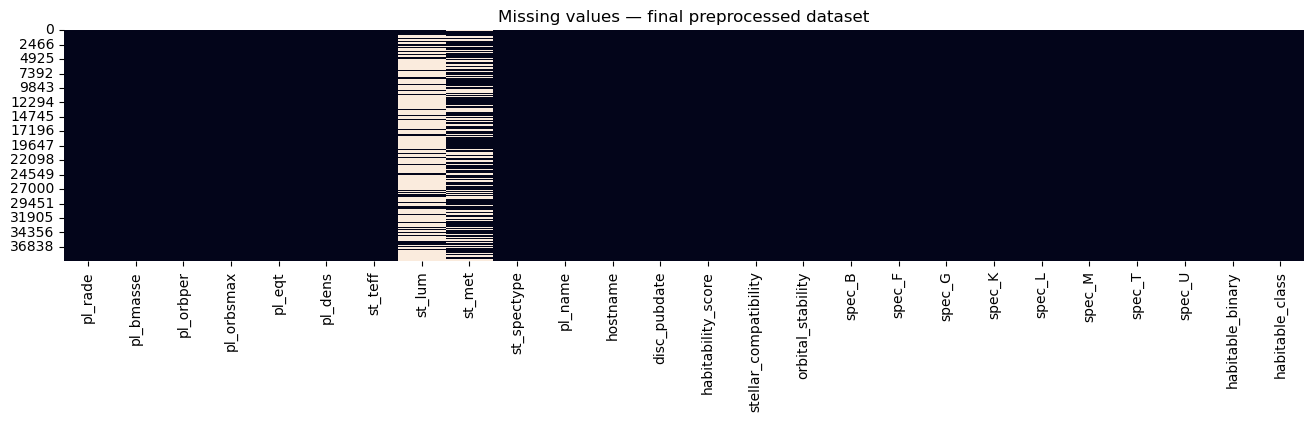

heatmap saved to ../notebooks/missing_heatmap_preprocessed.png


In [21]:
# Cell 19 — final checks
print("FINAL SHAPE:", df_work.shape)
print("TOTAL MISSING:", df_work.isnull().sum().sum())
print("DUPLICATES:", df_work.duplicated().sum())

# save summary stats
desc = df_work.describe(include='all').T
desc.to_csv("../notebooks/summary_stats_preprocessed.csv")
print("wrote summary stats to ../notebooks/summary_stats_preprocessed.csv")

# missing value heatmap (should be mostly blank if no missing)
plt.figure(figsize=(16,3))
sns.heatmap(df_work.isnull(), cbar=False)
plt.title("Missing values — final preprocessed dataset")
plt.savefig("../notebooks/missing_heatmap_preprocessed.png", bbox_inches='tight', dpi=150)
plt.show()
print("heatmap saved to ../notebooks/missing_heatmap_preprocessed.png")


In [24]:
# Cell 20 — save final preprocessed dataset to the exact path requested by spec
out_dir = os.path.join("..","data","preprocessed")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "preprocessed.csv")
df_work.to_csv(out_path, index=False)
print("Saved preprocessed dataset to:", out_path)


Saved preprocessed dataset to: ..\data\preprocessed\preprocessed.csv


In [28]:
import os
os.getcwd()


'c:\\Users\\shish\\Desktop\\B13-ExoHabitAI\\notebooks'

In [29]:
out_path = "../data/preprocessed/preprocessed.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: ../data/preprocessed/preprocessed.csv


In [30]:
import os
os.listdir("../data/preprocessed")


['preprocessed.csv']